In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [10]:
cd ..

/atlas/u/kechoi/multi-fairgen


In [11]:
from classification.models.mlp import MLPClassifier, MLPClassifierv2
from classification.models.flow_mlp import FlowClassifier
import argparse
import yaml

In [12]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    if isinstance(config, list):
        # from creating config files
        for i in range(len(config)):
            for key, value in config[i].items():
                if isinstance(value, dict):
                    new_value = dict2namespace(value)
                else:
                    new_value = value
                setattr(namespace, key, new_value)
    else:
        # vanilla training
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
    return namespace

# Load data

In [13]:
import torch
from torch.distributions import Normal

In [14]:
p = Normal(0, 1)
q = Normal(3, 1)

In [15]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

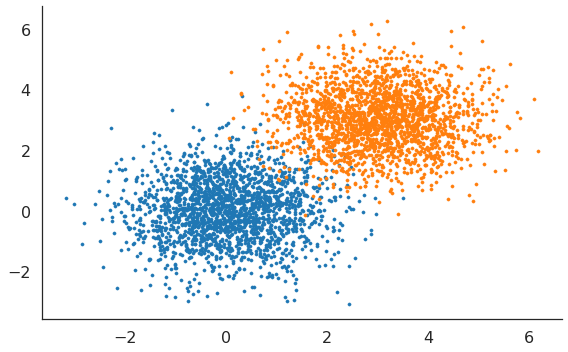

In [16]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label='px', s=10)
plt.scatter(qx[:,0], qx[:,1], label='qx', s=10)

plt.tight_layout()
sns.despine()

In [17]:
true_xs = torch.cat([qx, px])
true_xs.shape

torch.Size([4000, 2])

In [18]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))

In [19]:
true_log_r = torch.log(true_ratios)

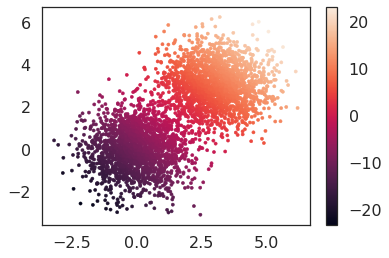

In [20]:
plt.scatter(true_xs[:,0].data.cpu().numpy(), true_xs[:,1].data.cpu().numpy(), s=10, c=true_log_r.data.cpu().numpy())
plt.colorbar()

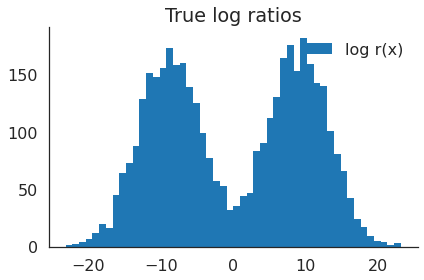

In [21]:
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('True log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

------

# dim = 20

### rho = 0.95

In [22]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [23]:
disc = np.load('classification/results/mi_disc_d40_perc1.0/est_mi.npy')
joint = np.load('classification/results/mi_joint_d40_alpha0.1/est_mi.npy')
joint1 = np.load('classification/results/mi_joint_d40_alpha0.5/est_mi.npy')
joint2 = np.load('classification/results/mi_joint_d40_alpha0.9/est_mi.npy')
joint3 = np.load('classification/results/mi_joint_d40_alpha0.9_rho0.9/est_mi.npy')

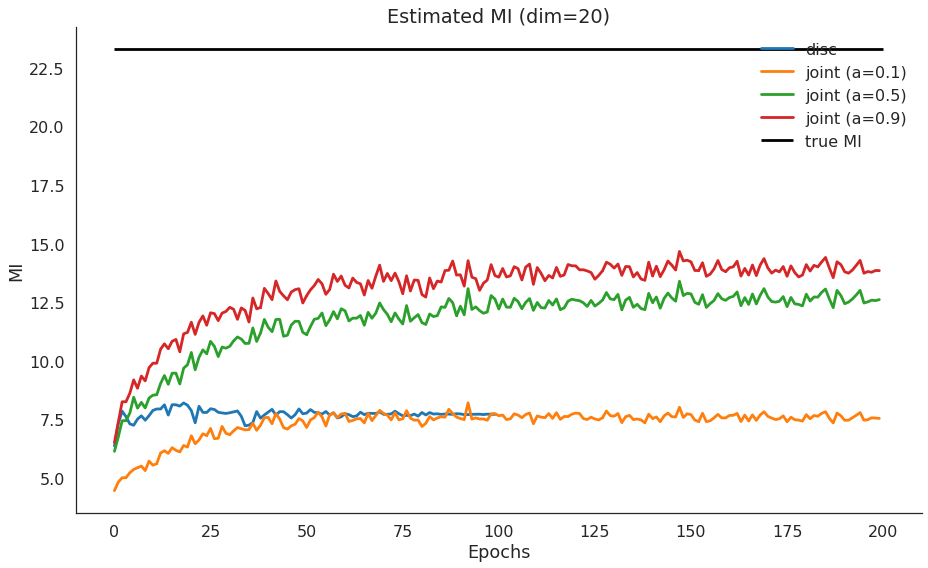

In [24]:
plt.figure(figsize=(13,8))

# plt.plot(range(len(disc)), disc, '-o', label='disc', markersize=7)
# # plt.plot(range(len(flow)), flow, '-o', label='flow', markersize=7)
# plt.plot(range(len(disc)), joint[0:100], '-o', label='joint (a=0.1)', markersize=7)
# plt.plot(range(len(disc)), joint1[0:100], '-o', label='joint (a=0.5)', markersize=7)
# plt.plot(range(len(disc)), joint2[0:100], '-o', label='joint (a=0.9)', markersize=7)
# # plt.plot(range(len(disc)), baseline, '-o', label='x-space baseline', markersize=7)

plt.plot(range(len(disc)), disc, '-o', label='disc', markersize=1)
# plt.plot(range(len(flow)), flow, '-o', label='flow', markersize=7)
plt.plot(range(len(joint)), joint, '-o', label='joint (a=0.1)', markersize=1)
plt.plot(range(len(joint)), joint1, '-o', label='joint (a=0.5)', markersize=1)
plt.plot(range(len(joint)), joint2, '-o', label='joint (a=0.9)', markersize=1)

plt.hlines(23.28, 0, len(joint), color='black', label='true MI')

plt.xlabel('Epochs')
plt.ylabel('MI')
# plt.ylim(0, 2)
plt.title('Estimated MI (dim=20)')
plt.legend()
sns.despine()
plt.tight_layout()

# START HERE

### rho = 0.9

In [30]:
baseline = np.load('classification/results/mi_d40_rho0.9/est_mi.npy')
joint1 = np.load('classification/results/mi_joint_d40_alpha0.1/est_mi.npy')[0:200]
joint2 = np.load('classification/results/mi_joint_d40_alpha0.5/est_mi.npy')[0:200]
joint3 = np.load('classification/results/mi_joint_d40_alpha0.9_rho0.9_v2/est_mi.npy')[0:200]
disc = np.load('classification/results/mi_disc_flow_d40_rho0.9/est_mi.npy')
sep = np.load('classification/results/mi_z_rho0.9/est_mi.npy')

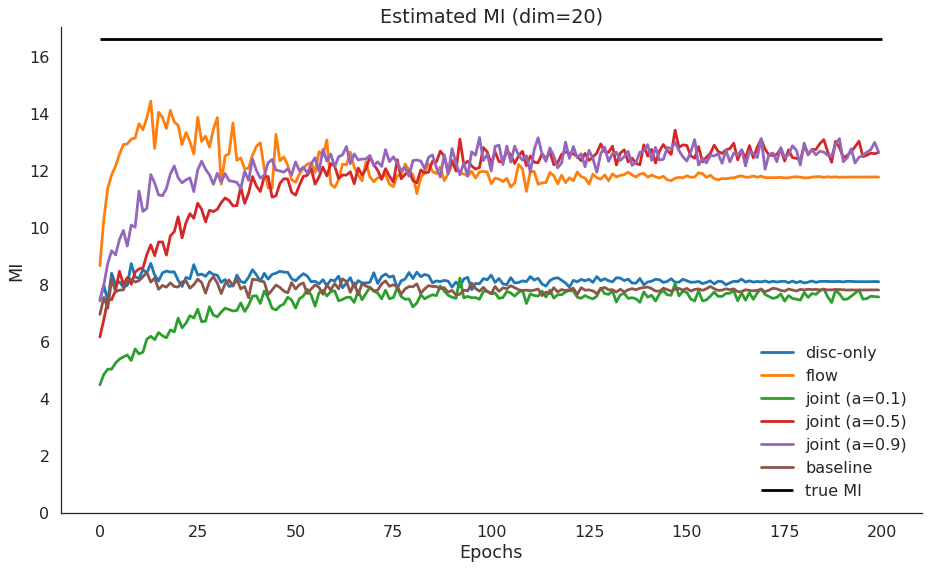

In [32]:
plt.figure(figsize=(13,8))

plt.plot(range(len(disc)), disc, '-o', label='disc-only', markersize=1)
plt.plot(range(len(sep)), sep, '-o', label='flow', markersize=1)
plt.plot(range(len(joint1)), joint1, '-o', label='joint (a=0.1)', markersize=1)
plt.plot(range(len(joint2)), joint2, '-o', label='joint (a=0.5)', markersize=1)
plt.plot(range(len(joint3)), joint3, '-o', label='joint (a=0.9)', markersize=1)
plt.plot(range(len(baseline)), baseline, '-o', label='baseline', markersize=1)

plt.hlines(16.61, 0, len(joint), color='black', label='true MI')

plt.xlabel('Epochs')
plt.ylabel('MI')
plt.ylim(0, 17)
plt.title('Estimated MI (dim=20)')
plt.legend()
sns.despine()
plt.tight_layout()

In [27]:
def rho_to_mi(dim, rho):
    """Obtain the ground truth mutual information from rho."""
    return -0.5 * np.log(1 - rho**2) * dim


def mi_to_rho(dim, mi):
    """Obtain the rho for Gaussian give ground truth mutual information."""
    return np.sqrt(1 - np.exp(-2.0 / dim * mi))

In [28]:
rho_to_mi(20,0.9)

16.607312068216512